#### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## Feature Engineering

In [2]:
order_final = pd.read_csv('order_final.csv')

In [3]:
order_final.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,count
0,0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0,1
1,1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0,1
2,2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,1
3,3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,1
4,4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0,1


In [4]:
order_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0              1384617 non-null  int64  
 1   order_id                1384617 non-null  int64  
 2   product_id              1384617 non-null  int64  
 3   add_to_cart_order       1384617 non-null  int64  
 4   reordered               1384617 non-null  int64  
 5   product_name            1384617 non-null  object 
 6   aisle_id                1384617 non-null  int64  
 7   department_id           1384617 non-null  int64  
 8   aisle                   1384617 non-null  object 
 9   department              1384617 non-null  object 
 10  user_id                 1384617 non-null  int64  
 11  eval_set                1384617 non-null  object 
 12  order_number            1384617 non-null  int64  
 13  order_dow               1384617 non-null  int64  
 14  or

In [5]:
order_final = order_final.drop(columns = ['Unnamed: 0'])


In [6]:
order_final.shape

(1384617, 16)

In [7]:
order_final.drop_duplicates(inplace=True)

In [8]:
order_final.shape

(1384617, 16)

#### Product reorder ratio

In [9]:
product_reorderd = order_final.groupby(by=['product_id'],as_index=False).agg({'product_name':'count', 'reordered':'sum'})
product_reorderd.head()

,product_id,product_name,reordered
0,1,76,49
1,2,4,1
2,3,6,6
3,4,22,14
4,5,1,1


In [10]:
product_reorderd = product_reorderd.rename(columns={'product_name': 'product_ordered_count', 'reordered' : 'product_reordered_count'})
product_reorderd.head(2)

,product_id,product_ordered_count,product_reordered_count
0,1,76,49
1,2,4,1


In [11]:
product_reorderd['product_reorder_ratio']=product_reorderd['product_reordered_count']/product_reorderd['product_ordered_count']
product_reorderd.head(2)

,product_id,product_ordered_count,product_reordered_count,product_reorder_ratio
0,1,76,49,0.644737
1,2,4,1,0.250000


In [12]:
order_final = pd.merge(order_final, product_reorderd, how='left', on='product_id')
order_final.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,count,product_ordered_count,product_reordered_count,product_reorder_ratio
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0,1,8,7,0.875000
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0,1,144,107,0.743056
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,1,1062,569,0.535782
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,1,2413,1709,0.708247
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0,1,24,10,0.416667


#### Time between next order made by user

In [13]:
time_bwn_order = order_final.groupby(by=['user_id'],as_index=False).agg({'days_since_prior_order':'mean'})
time_bwn_order = time_bwn_order.rename(columns={'days_since_prior_order': 'time_btwn_next_order'})
time_bwn_order.head(2)

,user_id,time_btwn_next_order
0,1,14.0
1,2,30.0


In [14]:
order_final = pd.merge(order_final, time_bwn_order, how='left', on='user_id')
order_final.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,count,product_ordered_count,product_reordered_count,product_reorder_ratio,time_btwn_next_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0,1,8,7,0.875000,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0,1,144,107,0.743056,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,1,1062,569,0.535782,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,1,2413,1709,0.708247,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0,1,24,10,0.416667,9.0


#### Department reorder ratio

In [15]:
department_reorderd = order_final.groupby(by=['department_id'],as_index=False).agg({'department':'count', 'reordered':'sum'})
department_reorderd = department_reorderd.rename(columns={'department': 'department_ordered_count', 'reordered' : 'department_reordered_count'})
department_reorderd['department_reorder_ratio']=department_reorderd['department_reordered_count']/department_reorderd['department_ordered_count']
department_reorderd.head()

,department_id,department_ordered_count,department_reordered_count,department_reorder_ratio
0,1,100426,56168,0.559297
1,2,1795,697,0.388301
2,3,48394,30692,0.634211
3,4,409087,271886,0.664617
4,5,5598,3397,0.606824


In [16]:
order_final = pd.merge(order_final, department_reorderd, how='left', on='department_id')
order_final.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,...,order_hour_of_day,days_since_prior_order,count,product_ordered_count,product_reordered_count,product_reorder_ratio,time_btwn_next_order,department_ordered_count,department_reordered_count,department_reorder_ratio
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,...,10,9.0,1,8,7,0.875000,9.0,217051,146502,0.674966
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,...,10,9.0,1,144,107,0.743056,9.0,217051,146502,0.674966
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,...,10,9.0,1,1062,569,0.535782,9.0,409087,271886,0.664617
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,...,10,9.0,1,2413,1709,0.708247,9.0,409087,271886,0.664617
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,...,10,9.0,1,24,10,0.416667,9.0,46799,22782,0.486805


#### Aisle reorder ratio


In [17]:
aisle_reorderd = order_final.groupby(by=['aisle_id'],as_index=False).agg({'aisle':'count', 'reordered':'sum'})
aisle_reorderd = aisle_reorderd.rename(columns={'aisle': 'aisle_ordered_count', 'reordered' : 'aisle_reordered_count'})
aisle_reorderd['aisle_reorder_ratio']=aisle_reorderd['aisle_reordered_count']/aisle_reorderd['aisle_ordered_count']
aisle_reorderd.head()

,aisle_id,aisle_ordered_count,aisle_reordered_count,aisle_reorder_ratio
0,1,2936,1754,0.597411
1,2,3873,1932,0.498838
2,3,17449,10429,0.597685
3,4,9917,5001,0.504286
4,5,2905,860,0.296041


In [18]:
order_final = pd.merge(order_final, aisle_reorderd, how='left', on='aisle_id')
order_final.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,...,product_ordered_count,product_reordered_count,product_reorder_ratio,time_btwn_next_order,department_ordered_count,department_reordered_count,department_reorder_ratio,aisle_ordered_count,aisle_reordered_count,aisle_reorder_ratio
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,...,8,7,0.875000,9.0,217051,146502,0.674966,55240,37939,0.686803
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,...,144,107,0.743056,9.0,217051,146502,0.674966,12820,7493,0.584477
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,...,1062,569,0.535782,9.0,409087,271886,0.664617,150609,91368,0.606657
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,...,2413,1709,0.708247,9.0,409087,271886,0.664617,150609,91368,0.606657
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,...,24,10,0.416667,9.0,46799,22782,0.486805,3241,1644,0.507251


In [19]:
order_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 0 to 1384616
Data columns (total 26 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   order_id                    1384617 non-null  int64  
 1   product_id                  1384617 non-null  int64  
 2   add_to_cart_order           1384617 non-null  int64  
 3   reordered                   1384617 non-null  int64  
 4   product_name                1384617 non-null  object 
 5   aisle_id                    1384617 non-null  int64  
 6   department_id               1384617 non-null  int64  
 7   aisle                       1384617 non-null  object 
 8   department                  1384617 non-null  object 
 9   user_id                     1384617 non-null  int64  
 10  eval_set                    1384617 non-null  object 
 11  order_number                1384617 non-null  int64  
 12  order_dow                   1384617 non-null  int64  
 1

# Modelling

In [20]:
correlations = order_final.corr()['reordered'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 department_ordered_count      0.122933
department_reordered_count    0.129458
product_reordered_count       0.149244
product_ordered_count         0.151593
department_reorder_ratio      0.197184
order_number                  0.223947
aisle_reorder_ratio           0.234629
product_reorder_ratio         0.350315
reordered                     1.000000
count                              NaN
Name: reordered, dtype: float64

Most Negative Correlations:
 days_since_prior_order   -0.160152
time_btwn_next_order     -0.160152
add_to_cart_order        -0.146393
department_id            -0.050294
order_hour_of_day        -0.017840
order_dow                -0.006714
user_id                  -0.004316
aisle_id                 -0.000172
order_id                  0.001418
product_id                0.006560
Name: reordered, dtype: float64


In [21]:
correlations

days_since_prior_order       -0.160152
time_btwn_next_order         -0.160152
add_to_cart_order            -0.146393
department_id                -0.050294
order_hour_of_day            -0.017840
order_dow                    -0.006714
user_id                      -0.004316
aisle_id                     -0.000172
order_id                      0.001418
product_id                    0.006560
aisle_ordered_count           0.107407
aisle_reordered_count         0.119132
department_ordered_count      0.122933
department_reordered_count    0.129458
product_reordered_count       0.149244
product_ordered_count         0.151593
department_reorder_ratio      0.197184
order_number                  0.223947
aisle_reorder_ratio           0.234629
product_reorder_ratio         0.350315
reordered                     1.000000
count                              NaN
Name: reordered, dtype: float64

In [22]:
order_final_modeling = order_final.drop(columns = ['count','aisle_id','order_id','product_id','user_id','department_id',
                                                   'product_name','eval_set','aisle','department','product_name',
                                                   'add_to_cart_order'])

In [23]:
features = order_final_modeling

In [24]:
X = features.drop(columns=['reordered'])
y = features['reordered']

In [25]:
X.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_ordered_count,product_reordered_count,product_reorder_ratio,time_btwn_next_order,department_ordered_count,department_reordered_count,department_reorder_ratio,aisle_ordered_count,aisle_reordered_count,aisle_reorder_ratio
0,4,4,10,9.0,8,7,0.875000,9.0,217051,146502,0.674966,55240,37939,0.686803
1,4,4,10,9.0,144,107,0.743056,9.0,217051,146502,0.674966,12820,7493,0.584477
2,4,4,10,9.0,1062,569,0.535782,9.0,409087,271886,0.664617,150609,91368,0.606657
3,4,4,10,9.0,2413,1709,0.708247,9.0,409087,271886,0.664617,150609,91368,0.606657
4,4,4,10,9.0,24,10,0.416667,9.0,46799,22782,0.486805,3241,1644,0.507251


In [26]:
y.head()

0    1
1    1
2    0
3    0
4    1
Name: reordered, dtype: int64

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 0 to 1384616
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   order_number                1384617 non-null  int64  
 1   order_dow                   1384617 non-null  int64  
 2   order_hour_of_day           1384617 non-null  int64  
 3   days_since_prior_order      1384617 non-null  float64
 4   product_ordered_count       1384617 non-null  int64  
 5   product_reordered_count     1384617 non-null  int64  
 6   product_reorder_ratio       1384617 non-null  float64
 7   time_btwn_next_order        1384617 non-null  float64
 8   department_ordered_count    1384617 non-null  int64  
 9   department_reordered_count  1384617 non-null  int64  
 10  department_reorder_ratio    1384617 non-null  float64
 11  aisle_ordered_count         1384617 non-null  int64  
 12  aisle_reordered_count       1384617 non-null  int64  
 1

In [28]:
X.shape

(1384617, 14)

In [29]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score



# Split the data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train shape: {X_train.shape}")
print(f"X validation shape: {X_valid.shape}")
print(f"X test shape: {X_test.shape}")

X train shape: (941539, 14)
X validation shape: (235385, 14)
X test shape: (207693, 14)


In [30]:
# Identify the numeric features we wish to consider. 
numerical_features = X.select_dtypes(include = ['int64','float64']).columns
numerical_features = numerical_features.tolist()

num_pipeline =Pipeline([('std',StandardScaler()),
                        ('imputer', SimpleImputer(strategy='mean'))
                       ])

data_pipeline = ColumnTransformer([
                                   ("num_pipeline", num_pipeline, numerical_features)],
                                    remainder='drop',
                                    n_jobs=-1
                                    )

features = numerical_features

data_pipeline.fit(X_train[features])
data_pipeline.fit(X_valid[features])

#transforming the X train, valid, and test sets.
X_train_transformed = data_pipeline.transform(X_train[features])
X_valid_transformed = data_pipeline.transform(X_valid[features])
X_test_transformed = data_pipeline.transform(X_test[features])


### Logistic Regression

In [32]:
#create a LR pipeline here
lr_clf = Pipeline([("lr", LogisticRegression(solver='saga'))])

#this pipeline is used for the accuracy measure/ fitting and train
lr_pipeline = make_pipeline(
    data_pipeline,
    lr_clf
)

lr_pipeline.fit(X_train, y_train)



#Here, we determine the accuracy scores for the train, validation, and test pipelines.
train_Acc = lr_pipeline.score(X_train, y_train)

valid_Acc = lr_pipeline.score(X_valid, y_valid)

test_Acc = lr_pipeline.score(X_test, y_test)

params = {'lr__C':[1.0, 10.0, 100.0], 
          'lr__penalty':['none', 'l1','l2']}

#using gridsearch here to determine the ROC-AUC scores for the train, validation, and test sets.
lr_gridsearch = GridSearchCV(lr_clf, param_grid = params, cv = 3, scoring='roc_auc', n_jobs = -1,verbose=1)

lr_gridsearch.fit(X_train_transformed, y_train)

results_df = pd.DataFrame(lr_gridsearch.cv_results_)
results_df = results_df.T
display(results_df)

lr_Model = lr_gridsearch.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


,0,1,2,3,4,5,6,7,8
mean_fit_time,11.51785,11.89173,11.504608,11.839061,12.391299,11.384557,13.446032,12.631421,8.245529
std_fit_time,0.26741,0.416597,0.287077,1.054529,0.719642,0.465997,0.470318,0.696531,0.532886
mean_score_time,0.293746,0.302004,0.265232,0.222783,0.242959,0.211151,0.197069,0.187466,0.11518
std_score_time,0.049582,0.00943,0.039881,0.020662,0.046494,0.004359,0.006223,0.026294,0.013526
param_lr__C,1.0,1.0,1.0,10.0,10.0,10.0,100.0,100.0,100.0
param_lr__penalty,none,l1,l2,none,l1,l2,none,l1,l2
params,"{'lr__C': 1.0, 'lr__penalty': 'none'}","{'lr__C': 1.0, 'lr__penalty': 'l1'}","{'lr__C': 1.0, 'lr__penalty': 'l2'}","{'lr__C': 10.0, 'lr__penalty': 'none'}","{'lr__C': 10.0, 'lr__penalty': 'l1'}","{'lr__C': 10.0, 'lr__penalty': 'l2'}","{'lr__C': 100.0, 'lr__penalty': 'none'}","{'lr__C': 100.0, 'lr__penalty': 'l1'}","{'lr__C': 100.0, 'lr__penalty': 'l2'}"
split0_test_score,0.741453,0.741452,0.741453,0.741453,0.741453,0.741454,0.741454,0.741453,0.741453
split1_test_score,0.742066,0.742065,0.742066,0.742065,0.742066,0.742065,0.742065,0.742065,0.742065
split2_test_score,0.740885,0.740884,0.740885,0.740885,0.740885,0.740885,0.740885,0.740885,0.740885


In [33]:
#forming the experiment log to track our results.
Log = pd.DataFrame(columns = ['Model Type', "TrainAcc", "ValidAcc", "TestAcc", 'Hyperparameters'])

Log = Log.append({'Model Type' : 'Logistic Regression',
                          'TrainAcc': train_Acc,
                          'ValidAcc': valid_Acc,
                          'TestAcc': test_Acc,
                          'TrainAuc': lr_gridsearch.best_score_,
                          'ValidAuc': roc_auc_score(y_valid, lr_Model.predict_proba(X_valid_transformed)[:, 1]),
                          'TestAuc': lr_gridsearch.score(X_test_transformed, y_test),
                          'Hyperparameters' : lr_gridsearch.best_params_},
                        ignore_index=True)

In [35]:
Log

,Model Type,TrainAcc,ValidAcc,TestAcc,Hyperparameters,TestAuc,TrainAuc,ValidAuc
0,Logistic Regression,0.688702,0.688056,0.689508,"{'lr__C': 100.0, 'lr__penalty': 'none'}",0.743162,0.741468,0.741013


### XGBoost

In [36]:
params={
 "xgb__learning_rate"    : [0.05, 0.10] ,
 "xgb__max_depth"        : [ 3,5],
 "xgb__min_child_weight" : [ 1, 3, 5]
}
classifier= xgboost.XGBClassifier()
pipeline_xgb = Pipeline([
        ("preparation", data_pipeline),
        ("xgb", xgboost.XGBClassifier())
    ])
random_search_xgb=RandomizedSearchCV(pipeline_xgb,param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=3,verbose=1)
random_search_xgb.fit(X_train,y_train)


xgboostmodel= random_search_xgb.best_estimator_

random_search_xgb.best_params_

results_df = pd.DataFrame(random_search_xgb.cv_results_)
results_df = results_df.T
display(results_df)



Fitting 3 folds for each of 5 candidates, totalling 15 fits
[16:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,0,1,2,3,4
mean_fit_time,133.093552,132.857559,235.948051,147.157918,182.162861
std_fit_time,1.321981,1.01548,16.574736,0.920186,43.241631
mean_score_time,2.513913,2.643512,3.239177,1.702428,0.938054
std_score_time,0.110131,0.108434,1.406898,0.33314,0.120771
param_xgb__min_child_weight,3,1,3,3,5
param_xgb__max_depth,3,3,5,3,5
param_xgb__learning_rate,0.1,0.1,0.1,0.05,0.1
params,"{'xgb__min_child_weight': 3, 'xgb__max_depth':...","{'xgb__min_child_weight': 1, 'xgb__max_depth':...","{'xgb__min_child_weight': 3, 'xgb__max_depth':...","{'xgb__min_child_weight': 3, 'xgb__max_depth':...","{'xgb__min_child_weight': 5, 'xgb__max_depth':..."
split0_test_score,0.697184,0.697184,0.697821,0.696495,0.697821
split1_test_score,0.6981,0.698088,0.698116,0.697428,0.698269


In [40]:
Log = Log.append({'Model Type' : 'XGBoost',
                          'TrainAcc': train_Acc,
                          'ValidAcc': valid_Acc,
                          'TestAcc': test_Acc,
                          'TrainAuc': random_search_xgb.best_score_,
                          'ValidAuc':"",
                          'TestAuc': "",
                          'Hyperparameters' : random_search_xgb.best_params_},
                        ignore_index=True)

In [41]:
random_search_xgb.best_params_

{'xgb__min_child_weight': 5, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1}

In [42]:
Log

,Model Type,TrainAcc,ValidAcc,TestAcc,Hyperparameters,TestAuc,TrainAuc,ValidAuc
0,Logistic Regression,0.688702,0.688056,0.689508,"{'lr__C': 100.0, 'lr__penalty': 'none'}",0.743162,0.741468,0.741013
1,XGBoost,0.688702,0.688056,0.689508,"{'xgb__min_child_weight': 5, 'xgb__max_depth':...",,0.698172,


### Random Forest

In [43]:
pipeline_rf = Pipeline([
        ("preparation", data_pipeline),
        ("rmf", RandomForestClassifier())
    ])
param_grid = {
    'rmf__bootstrap': [True],
    'rmf__max_depth': [10, 20],
    'rmf__max_features': [2, 3],
    'rmf__n_estimators': [100, 200]
}

grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search_rf.cv_results_)
results_df = results_df.T
display(results_df)

rfModel = grid_search_rf.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


,0,1,2,3,4,5,6,7
mean_fit_time,241.985399,527.224603,347.914525,780.515034,449.68733,875.358257,568.585584,703.731121
std_fit_time,4.179379,2.775008,24.22651,10.465992,9.523333,7.85533,3.530578,136.897397
mean_score_time,14.576681,28.063708,12.989338,26.363928,36.070028,68.263864,28.957,24.856405
std_score_time,0.452075,0.782914,0.444771,1.237864,0.55754,19.005027,0.942683,5.839275
param_rmf__bootstrap,True,True,True,True,True,True,True,True
param_rmf__max_depth,10,10,10,10,20,20,20,20
param_rmf__max_features,2,2,3,3,2,2,3,3
param_rmf__n_estimators,100,200,100,200,100,200,100,200
params,"{'rmf__bootstrap': True, 'rmf__max_depth': 10,...","{'rmf__bootstrap': True, 'rmf__max_depth': 10,...","{'rmf__bootstrap': True, 'rmf__max_depth': 10,...","{'rmf__bootstrap': True, 'rmf__max_depth': 10,...","{'rmf__bootstrap': True, 'rmf__max_depth': 20,...","{'rmf__bootstrap': True, 'rmf__max_depth': 20,...","{'rmf__bootstrap': True, 'rmf__max_depth': 20,...","{'rmf__bootstrap': True, 'rmf__max_depth': 20,..."
split0_test_score,0.693873,0.693714,0.695673,0.695756,0.689604,0.690381,0.68997,0.690101


In [45]:
Log = Log.append({'Model Type' : 'Random Forest',
                          'TrainAcc': train_Acc,
                          'ValidAcc': valid_Acc,
                          'TestAcc': test_Acc,
                          'TrainAuc': grid_search_rf.best_score_,
                          'ValidAuc': "",
                          'TestAuc': "",
                          'Hyperparameters' : grid_search_rf.best_params_},
                        ignore_index=True)

In [46]:
grid_search_rf.best_params_

{'rmf__bootstrap': True,
 'rmf__max_depth': 10,
 'rmf__max_features': 3,
 'rmf__n_estimators': 200}

In [47]:
Log

,Model Type,TrainAcc,ValidAcc,TestAcc,Hyperparameters,TestAuc,TrainAuc,ValidAuc
0,Logistic Regression,0.688702,0.688056,0.689508,"{'lr__C': 100.0, 'lr__penalty': 'none'}",0.743162,0.741468,0.741013
1,XGBoost,0.688702,0.688056,0.689508,"{'xgb__min_child_weight': 5, 'xgb__max_depth':...",,0.698172,
2,Random Forest,0.688702,0.688056,0.689508,"{'rmf__bootstrap': True, 'rmf__max_depth': 10,...",,0.696206,


## Hyperparameter Tuning for the models

### Logistic Regression

In [48]:
Log2 = pd.DataFrame(columns=["exp_name", 
                                "Train Acc", 
                                "Valid Acc",
                                "Test  Acc",
                                "Train AUC", 
                                "Valid AUC",
                                "Test  AUC",
                                "Train F1",
                                "Valid F1",
                                "Test F1"
                                ])

In [49]:
full_pipeline_with_predictor_clf = Pipeline([
        ("preparation", data_pipeline),
        ("linear", LogisticRegression(C=100,penalty='l2', solver='saga'))
    ])
model_lr = full_pipeline_with_predictor_clf.fit(X_train, y_train)


In [50]:
from sklearn.metrics import accuracy_score

np.round(accuracy_score(y_train, model_lr.predict(X_train)), 3)

0.689

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, model_lr.predict_proba(X_train)[:, 1])

0.7414854316762807

In [52]:
from sklearn.metrics import f1_score
f1_score(y_train, model_lr.predict(X_train), average='weighted')

0.6775230483264779

In [54]:
exp_name = f"Logicistic_Regression"
Log2.loc[len(Log2)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_lr.predict(X_train)), 
                accuracy_score(y_valid, model_lr.predict(X_valid)),
                accuracy_score(y_test, model_lr.predict(X_test)),
                roc_auc_score(y_train, model_lr.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_lr.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_lr.predict_proba(X_test)[:, 1]),
                f1_score(y_train, model_lr.predict(X_train), average='weighted'),
                f1_score(y_valid, model_lr.predict(X_valid), average='weighted'),
                f1_score(y_test, model_lr.predict(X_test), average='weighted')],             
    4)) 
Log2

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train F1,Valid F1,Test F1
0,Logicistic_Regression,0.6887,0.6881,0.6895,0.7415,0.741,0.7432,0.6775,0.6767,0.6781


Score 0.7431618444432652


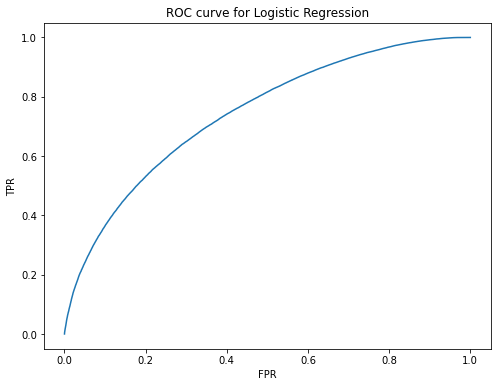

In [55]:
from sklearn import metrics
train_acc = model_lr.score(X_train, y_train)
validAcc  = model_lr.score(X_valid, y_valid)
testAcc  = model_lr.score(X_test, y_test)
    
predictions = model_lr.predict_proba(X_test)
print ("Score",roc_auc_score(y_test, predictions[:,1]))  
    
fpr, tpr, _ = metrics.roc_curve(y_test, predictions[:,1])
plt.figure(figsize=(8,6))
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Logistic Regression')
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

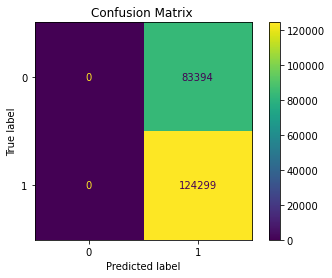

In [56]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
plt.clf()
plt.figure(figsize=(8,6))
plot_confusion_matrix(lr_gridsearch,X_test, y_test)
plt.title('Confusion Matrix ')
plt.show()

### XGBoost

In [57]:
full_pipeline_with_predictor_xgb = Pipeline([
        ("preparation", data_pipeline),
        ("xgboost", xgboost.XGBClassifier(min_child_weight = 5,max_depth=5,learning_rate=0.1))
    ])

model_xgb = full_pipeline_with_predictor_xgb.fit(X_train, y_train)

[17:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [58]:
np.round(accuracy_score(y_train, model_xgb.predict(X_train)), 3)


0.699

In [59]:
roc_auc_score(y_train, model_xgb.predict_proba(X_train)[:, 1])


0.7555100195295783

In [60]:
f1_score(y_train, model_xgb.predict(X_train), average='weighted')


0.6906113850527789

In [61]:
exp_name = f"XGBoost"
Log2.loc[len(Log2)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_xgb.predict(X_train)), 
                accuracy_score(y_valid, model_xgb.predict(X_valid)),
                accuracy_score(y_test, model_xgb.predict(X_test)),
                roc_auc_score(y_train, model_xgb.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1]),
                f1_score(y_train, model_xgb.predict(X_train), average='weighted'),
                f1_score(y_valid, model_xgb.predict(X_valid), average='weighted'),
                f1_score(y_test, model_xgb.predict(X_test), average='weighted')],
    4)) 

Log2

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train F1,Valid F1,Test F1
0,Logicistic_Regression,0.6887,0.6881,0.6895,0.7415,0.7410,0.7432,0.6775,0.6767,0.6781
1,XGBoost,0.6990,0.6976,0.6989,0.7555,0.7539,0.7558,0.6906,0.6891,0.6902


Score: 0.7558211561596511


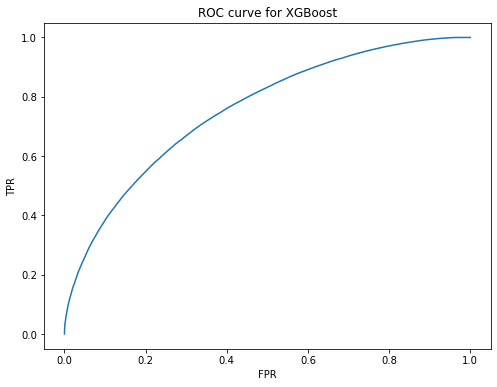

In [62]:
train_acc = model_xgb.score(X_train, y_train)
validAcc  = model_xgb.score(X_valid, y_valid)
testAcc  = model_xgb.score(X_test, y_test)
    
predictions = model_xgb.predict_proba(X_test)
print ("Score:",roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = metrics.roc_curve(y_test, predictions[:,1])
plt.figure(figsize=(8,6))
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for XGBoost')
plt.show()

<Figure size 432x288 with 0 Axes>

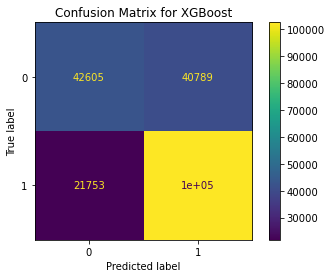

In [63]:
plt.clf()
plot_confusion_matrix(random_search_xgb,X_test, y_test)
plt.title('Confusion Matrix for XGBoost')
plt.show()

### Random Forest

In [64]:
full_pipeline_with_rfpredictor = Pipeline([
        ("preparation", data_pipeline),
        ("linear", RandomForestClassifier(bootstrap = True,max_depth = 10, max_features = 3, n_estimators = 200))
    ])
model_rf = full_pipeline_with_rfpredictor.fit(X_train, y_train)

In [65]:
roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1])

0.754889950736242

In [66]:
f1_score(y_train, model_rf.predict(X_train), average='weighted')

0.6877463381268232

In [67]:
exp_name = "Random Forest "
Log2.loc[len(Log2)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_rf.predict(X_train)),
                accuracy_score(y_valid, model_rf.predict(X_valid)),
                accuracy_score(y_test, model_rf.predict(X_test)),
                roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_rf.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]),
                f1_score(y_train, model_rf.predict(X_train), average='weighted'),
                f1_score(y_valid, model_rf.predict(X_valid), average='weighted'),
                f1_score(y_test, model_rf.predict(X_test), average='weighted')],
                
    4)) 

In [68]:
Log2

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train F1,Valid F1,Test F1
0,Logicistic_Regression,0.6887,0.6881,0.6895,0.7415,0.7410,0.7432,0.6775,0.6767,0.6781
1,XGBoost,0.6990,0.6976,0.6989,0.7555,0.7539,0.7558,0.6906,0.6891,0.6902
2,Random Forest,0.6988,0.6953,0.6974,0.7549,0.7505,0.7521,0.6877,0.6840,0.6859


Score 0.7520791968411638


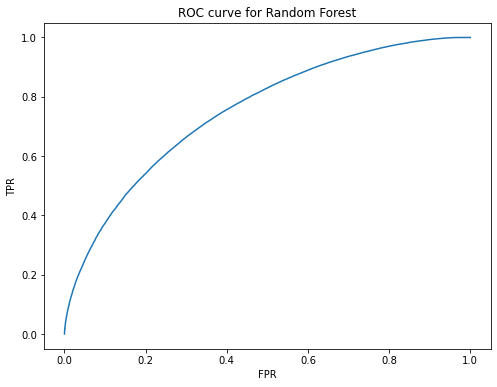

In [71]:
train_acc = model_rf.score(X_train, y_train)
validAcc  = model_rf.score(X_valid, y_valid)
testAcc  = model_rf.score(X_test, y_test)
    
predictions = model_rf.predict_proba(X_test)
print ("Score",roc_auc_score(y_test, predictions[:,1]))
    
    
fpr, tpr, _ = metrics.roc_curve(y_test, predictions[:,1])
plt.figure(figsize=(8,6))
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Random Forest')
plt.show()

<Figure size 432x288 with 0 Axes>

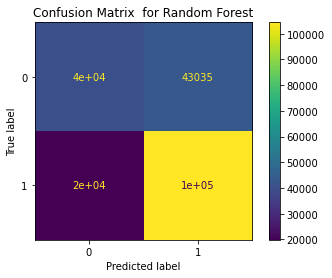

In [72]:
plt.clf()
plot_confusion_matrix(grid_search_rf,X_test, y_test)
plt.title('Confusion Matrix  for Random Forest')
plt.show()

In [73]:
order_final.to_csv('order_final.csv')

### References

- https://asagar60.medium.com/instacart-market-basket-analysis-part-2-fe-modelling-1dc02c2b028b
- https://asagar60.medium.com/instacart-market-basket-analysis-part-1-introduction-eda-b08fd8250502
- https://www.kaggle.com/code/kanchanlakhlan/insta-cart-eda
- https://www.kaggle.com/code/jungeun0121/instacart-market-basket-analysis-basiceda2
- https://www.kaggle.com/code/viveksrinivasan/eda-on-instacart-market-basket-analysis/notebook
- https://towardsdatascience.com/instacart-users-segmentation-and-market-basket-analysis-d88378f75f73
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- https://towardsdatascience.com/roc-curve-and-auc-explained-8ff3438b3154